# Final Processing of AKARI-SEP Blind source catalogue

![HELP LOGO](https://avatars1.githubusercontent.com/u/7880370?s=100&v=4>)


The final processing stage requires:
1. Quick validation of blind catalogues and Bayesian Pvalue maps
2. Skewness level
3. Adding flag to catalogue
4. Merging MF catalogue with XID+ flux densities

In [1]:
import seaborn as sns
from astropy.table import Table,hstack
%matplotlib inline
import numpy as np
import pylab as plt

from astropy import units as u
from astropy.table import Column

import herschelhelp_internal
from herschelhelp_internal.utils import gen_help_id
import numpy.core.defchararray as np_f


## Read tables

In [2]:
cat=Table.read('./data/dmu22_XID+SPIRE_AKARI-SEP_BLIND.fits')
cat['RA'].unit=u.deg
cat['Dec'].unit=u.deg

In [3]:
cat[0:10]

HELP_ID,RA,Dec,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500
,deg,deg,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,
bytes27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
161,68.8020187998,-55.6440361386,90.6751,94.6894,86.9403,56.1904,59.1176,52.3942,23.28,28.2572,18.5154,-0.0152475,-0.0258911,-0.0185354,0.00263353,0.0037064,0.0054025,0.998708,0.998871,0.998499,2000.0,2000.0,2000.0,0.0,0.0,0.0
181,68.5880998683,-55.6961908448,73.7079,77.0619,70.2107,24.2188,28.231,20.2233,18.1494,22.6425,13.7172,-0.0152475,-0.0258911,-0.0185354,0.00263353,0.0037064,0.0054025,0.998875,0.998718,0.999774,2000.0,2000.0,2000.0,0.0,0.0,0.0
541,68.8230689476,-55.5658228559,70.8249,72.371,68.5648,40.3171,43.2259,37.2499,20.4809,24.1774,16.9316,-0.0152475,-0.0258911,-0.0185354,0.00263353,0.0037064,0.0054025,0.998847,0.999684,0.998552,2000.0,2000.0,2000.0,0.0,0.0,0.0
642,68.6287515644,-55.7188357237,59.357,63.3315,55.1739,54.0893,58.3802,49.214,33.7704,38.8375,28.3352,-0.0152475,-0.0258911,-0.0185354,0.00263353,0.0037064,0.0054025,0.999691,1.00291,0.998655,2000.0,2000.0,2000.0,0.0,0.0,0.0
664,68.8008493081,-55.6279189937,51.9882,55.0119,48.8849,39.8744,43.8657,36.0955,19.6603,24.3778,14.9069,-0.0152475,-0.0258911,-0.0185354,0.00263353,0.0037064,0.0054025,0.999397,0.999246,0.999056,2000.0,2000.0,2000.0,0.0,0.0,0.0
687,68.798123027,-55.5440483187,66.2075,68.3232,63.5279,57.231,60.1696,54.6927,29.1387,32.3431,25.8108,-0.0152475,-0.0258911,-0.0185354,0.00263353,0.0037064,0.0054025,0.999843,1.00022,0.998647,2000.0,2000.0,2000.0,0.0,0.0,0.0
1689,68.7813403263,-55.5459964134,41.0318,44.0495,38.2452,18.3104,21.2739,15.515,8.96984,12.4885,5.3071,-0.0152475,-0.0258911,-0.0185354,0.00263353,0.0037064,0.0054025,0.999731,0.998424,1.00072,2000.0,2000.0,2000.0,0.0,0.0,0.0
2034,68.7248348692,-55.6716333554,15.9437,20.2787,11.5358,4.4596,8.05879,1.71683,6.42226,10.8046,2.45879,-0.0152475,-0.0258911,-0.0185354,0.00263353,0.0037064,0.0054025,0.998484,0.99931,0.999715,2000.0,2000.0,2000.0,0.0,0.0,0.0


## Look at Symmetry of PDFs to determine depth level of catalogue

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


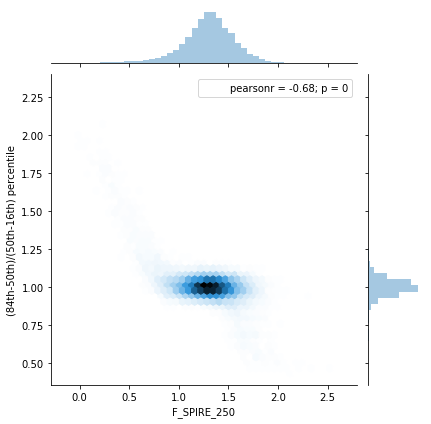

In [4]:
skew=(cat['FErr_SPIRE_250_u']-cat['F_SPIRE_250'])/(cat['F_SPIRE_250']-cat['FErr_SPIRE_250_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_250']),y=skew, kind='hex')

For 250 $\mathrm{\mu m}$ depth is ~ 6mJy

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


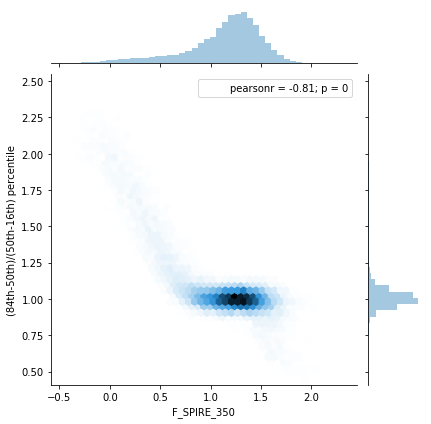

In [5]:
skew=(cat['FErr_SPIRE_350_u']-cat['F_SPIRE_350'])/(cat['F_SPIRE_350']-cat['FErr_SPIRE_350_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_350']),y=skew, kind='hex')


For 350 $\mathrm{\mu m}$ depth is ~ 6mJy

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


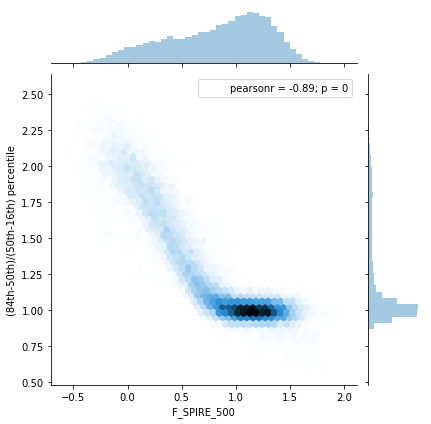

In [6]:
skew=(cat['FErr_SPIRE_500_u']-cat['F_SPIRE_500'])/(cat['F_SPIRE_500']-cat['FErr_SPIRE_500_l'])
skew.name='(84th-50th)/(50th-16th) percentile'
g=sns.jointplot(x=np.log10(cat['F_SPIRE_500']),y=skew, kind='hex')


For 500 $\mathrm{\mu m}$ depth is ~ 6mJy

## Add flag to catalogue

In [7]:
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_250'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_350'))
cat.add_column(Column(np.zeros(len(cat), dtype=bool),name='flag_spire_500'))

In [8]:
ind_250=(cat['Pval_res_250']>0.5) | (cat['F_SPIRE_250'] < 6)
ind_350=(cat['Pval_res_350']>0.5) | (cat['F_SPIRE_350'] < 6)
ind_500=(cat['Pval_res_500']>0.5) | (cat['F_SPIRE_500'] < 6)

In [9]:
print(ind_250.sum(),ind_350.sum(),ind_500.sum(),len(cat))

1538 3525 8333 20169


In [10]:
cat['flag_spire_250'][ind_250]=True
cat['flag_spire_350'][ind_350]=True
cat['flag_spire_500'][ind_500]=True

In [145]:
# set XID+ cahtalogue back to orignal order of objects, as used in MF detection files
use = cat['HELP_ID'].astype(int) -1
use = np.argsort(use)
cat = cat[use]

In [11]:
# Reads MF table, removes duplicate RA and DEC
cat2=Table.read('./data/AKARI-SEP_SPIRE_all.fits')
del cat2['RA']
del cat2['Dec']
cat_all = hstack([cat,cat2])

In [12]:
# Created HELP_ID, and changes HELP to HELP_BLIND to avoid confusion with HELP-Masterlist objects
ID = gen_help_id(cat_all['RA'], cat_all['Dec'])
ID_new = [IDs.replace('HELP','HELP_BLIND') for IDs in ID]
ID_new = Column(ID_new,name="HELP_ID")
cat_all['HELP_ID'] = ID_new

In [13]:
# all flux denisties are in mJy in the final BLIND catalogues
cat_all['F_BLIND_MF_SPIRE_250'].unit = 'mJy'
cat_all['F_BLIND_MF_SPIRE_250'] = 1000*cat_all['F_BLIND_MF_SPIRE_250']
cat_all['FErr_BLIND_MF_SPIRE_250'].unit = 'mJy'
cat_all['FErr_BLIND_MF_SPIRE_250'] = 1000*cat_all['FErr_BLIND_MF_SPIRE_250']

cat_all['F_BLIND_MF_SPIRE_350'].unit = 'mJy'
cat_all['F_BLIND_MF_SPIRE_350'] = 1000*cat_all['F_BLIND_MF_SPIRE_350']
cat_all['FErr_BLIND_MF_SPIRE_350'].unit = 'mJy'
cat_all['FErr_BLIND_MF_SPIRE_350'] = 1000*cat_all['FErr_BLIND_MF_SPIRE_350']

cat_all['F_BLIND_MF_SPIRE_500'].unit = 'mJy'
cat_all['F_BLIND_MF_SPIRE_500'] = 1000*cat_all['F_BLIND_MF_SPIRE_500']
cat_all['FErr_BLIND_MF_SPIRE_500'].unit = 'mJy'
cat_all['FErr_BLIND_MF_SPIRE_500'] = 1000*cat_all['FErr_BLIND_MF_SPIRE_500']

cat_all['F_BLIND_pix_SPIRE'].unit = 'mJy'
cat_all['F_BLIND_pix_SPIRE'] = 1000*cat_all['F_BLIND_pix_SPIRE']
cat_all['FErr_BLIND_pix_SPIRE'].unit = 'mJy'
cat_all['FErr_BLIND_pix_SPIRE'] = 1000*cat_all['FErr_BLIND_pix_SPIRE']


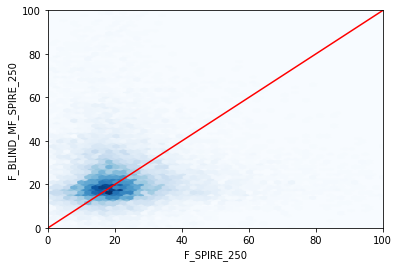

In [15]:
# XID+ flux density vs. MF flux densities
plt.hexbin(cat_all['F_SPIRE_250'],cat_all['F_BLIND_MF_SPIRE_250'], cmap=plt.cm.Blues,gridsize=(300,300))
plt.plot([0,100],[0,100], color = 'red')
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('F_SPIRE_250')
plt.ylabel('F_BLIND_MF_SPIRE_250')
plt.show()


In [150]:
# Add field name
cat_all.add_column(Column(['AKARI-SEP']*len(cat_all),name='field'))


In [151]:
cat_all.write('./data/dmu22_XID+SPIRE_AKARI-SEP_BLIND_Matched_MF.fits', format='fits',overwrite=True)

*This is a default HELP jupyter notebook *

 ![HELP LOGO](https://avatars1.githubusercontent.com/u/7880370?s=75&v=4)

**Authors**: S. Duivenvoorden

 
For a full description of the database and how it is organised in to `dmu_products` please the top level [readme](../readme.md).
 
The Herschel Extragalactic Legacy Project, ([HELP](http://herschel.sussex.ac.uk/)), is a [European Commission Research Executive Agency](https://ec.europa.eu/info/departments/research-executive-agency_en)
funded project under the SP1-Cooperation, Collaborative project, Small or medium-scale focused research project, FP7-SPACE-2013-1 scheme, Grant Agreement
Number 607254.

[Acknowledgements](http://herschel.sussex.ac.uk/acknowledgements)